In [1]:
import time
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import uniform, randint
from rdkit import Chem
from rdkit.Chem import Draw

from sklearn.preprocessing import OneHotEncoder,StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import PredictionErrorDisplay as PED
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error,root_mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold,RandomizedSearchCV,GridSearchCV
import pickle
from joblib import dump, load

In [ ]:
X=pd.read_pickle("data/processed/calc_descriptors_final.pkl")
print("n_features: ", len(X.columns))

print(X['Ipc'].max(),X['Ipc'].min())
scaler = MinMaxScaler()
X['Ipc'] = scaler.fit_transform(X['Ipc'].values.reshape(-1,1))
#veryfy scaling
print(X['Ipc'].max(),X['Ipc'].min())


scaler=StandardScaler().fit(X)
scaled=scaler.transform(X)

df=pd.read_pickle("data/processed/gap_smile.pkl")
y=df["GAP"].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(scaled,y,test_size=0.3,random_state=42)

n_features:  56
219.2769658075064 1.0851048673387407
1.0 0.0


In [3]:
load_file='data/processed/reg_NN_MLP.joblib'
reg=load(load_file)

/home/sat/miniforge3/envs/py310hl_gaps_pub/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
#predict all 
gap_pred=reg.predict(scaled)
print(len(gap_pred))

406203


In [5]:
df["GAP_P"]=gap_pred

In [6]:
def get_metrics(df,pred,test):
    #print(df)
    y_pred=df[pred]
    y_test=df[test]
    r2=r2_score(y_pred=y_pred,y_true=y_test)
    mse=mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    
    return r2,mse,mae,rmse

### general analysis

In [7]:
#prediction on trained molecules

y_pred_train=reg.predict(X_train)

mse = mean_squared_error(y_train, y_pred_train)
print("The mean squared error (MSE)  on test set: {:.4f}".format(mse))
rmse = root_mean_squared_error(y_train, y_pred_train)
print("The mean squared error (RMSE) on test set: {:.4f}".format(rmse))
mae = mean_absolute_error(y_train, y_pred_train)
print("The mean squared error (MAE)  on test set: {:.4f}".format(mae))

print("R2-score:",r2_score(y_pred=y_pred_train,y_true=y_train))

The mean squared error (MSE)  on test set: 0.0551
The mean squared error (RMSE) on test set: 0.2347
The mean squared error (MAE)  on test set: 0.1733
R2-score: 0.966901489235207


### general analysis

In [8]:
#prediction on untrained/test molecules

y_pred=reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("The mean squared error (MSE)  on test set: {:.4f}".format(mse))
rmse = root_mean_squared_error(y_test, y_pred)
print("The mean squared error (RMSE) on test set: {:.4f}".format(rmse))
mae = mean_absolute_error(y_test, y_pred)
print("The mean squared error (MAE)  on test set: {:.4f}".format(mae))

print("R2-score:",r2_score(y_pred=y_pred,y_true=y_test))

The mean squared error (MSE)  on test set: 0.0907
The mean squared error (RMSE) on test set: 0.3012
The mean squared error (MAE)  on test set: 0.2121
R2-score: 0.9455896445822082


In [29]:
df_concat=pd.concat([df,X],axis=1,join='inner')
df_concat['diff']=df_concat['GAP']-df_concat['GAP_P']

In [27]:
# metrics of the whole set
r2,mse,mae,rmse=get_metrics(df_concat,"GAP_P","GAP")
r2,mse,mae,rmse

(0.9605007179840162,
 0.06578637565551436,
 0.18494332273434758,
 0.2564885487804755)

In [12]:
#metrics for subsets of descriptors
results = []
for descr in df_concat.columns:
    if any(sub in descr for sub in ["Num", "fr"]) : #
        df_tmp= df_concat[df_concat[descr]>0]
        #print(descr,type(descr), len(df_tmp))
        r2,mse,mae,rmse=get_metrics(df_tmp,"GAP_P","GAP")
        #print(r2,mse,mae,rmse)
        results.append({
            "descriptor": descr,
            "R2": r2,
            "MSE": mse,
            "MAE": mae,
            "RMSE": rmse,
        })

In [13]:
metrics_df = pd.DataFrame(results)
metrics_df.sort_values(by="R2",ascending=False)
metrics_df.style.format({"R2": "{:.3f}", "MSE": "{:.3f}", "MaE": "{:.3f}", "RMSE": "{:.3f}"})

,descriptor,R2,MSE,MAE,RMSE
0,NumRadicalElectrons,0.506,0.319,0.434290,0.565
1,NumAliphaticHeterocycles,0.954,0.068,0.190391,0.262
2,NumAromaticCarbocycles,0.896,0.054,0.169880,0.231
3,NumAromaticHeterocycles,0.868,0.051,0.166263,0.227
4,fr_Al_COO,0.888,0.070,0.192385,0.265
5,fr_Al_OH_noTert,0.852,0.101,0.229123,0.318
6,fr_Ar_N,0.860,0.060,0.180439,0.245
7,fr_NH0,0.914,0.072,0.193936,0.268
8,fr_NH2,0.936,0.104,0.225950,0.322
9,fr_allylic_oxid,0.934,0.068,0.189421,0.260


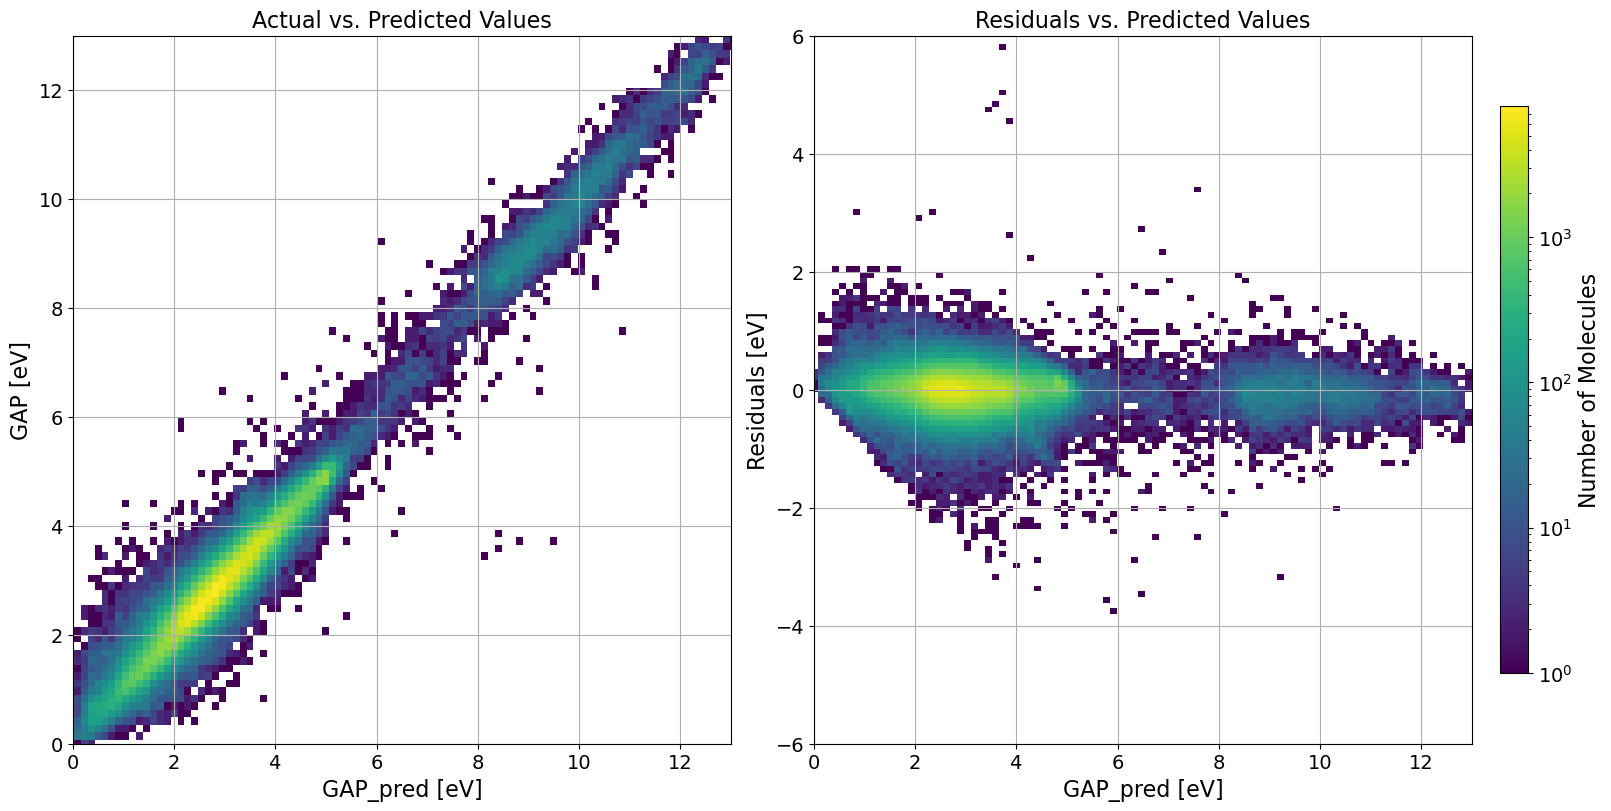

In [ ]:
# Define data for the first plot
x1 = df_concat['GAP']
y1 = df_concat['GAP_P']
heatmap1, xedges1, yedges1 = np.histogram2d(x1, y1, bins=100, density=False)

# Define data for the second plot
x2 = df_concat['GAP_P']
y2 = df_concat['diff']
heatmap2, xedges2, yedges2 = np.histogram2d(x2, y2, bins=100, density=False)

# Determine shared color scale
vmin = min(heatmap1[heatmap1 > 0].min(), heatmap2[heatmap2 > 0].min(), 1e0)
vmax = max(heatmap1.max(), heatmap2.max())

# Create a subplot with 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

# First subplot: Actual vs. Predicted
im1 = axs[0].imshow(
    heatmap1.T,
    extent=[xedges1[0], xedges1[-1], yedges1[0], yedges1[-1]],
    origin='lower',
    cmap='viridis',
    aspect='auto',
    norm=LogNorm(vmin=vmin, vmax=vmax)
)
axs[0].set_xlim(0, 13)
axs[0].set_ylim(0, 13)
axs[0].grid()
axs[0].tick_params(axis='both', which='major', labelsize=14)  # Change tick label font size
axs[0].set_xlabel('GAP_pred [eV]',fontsize=16)
axs[0].set_ylabel('GAP [eV]',fontsize=16)
axs[0].set_title('Actual vs. Predicted Values',fontsize=16)

# Second subplot: Residuals vs. Predicted
im2 = axs[1].imshow(
    heatmap2.T,
    extent=[xedges2[0], xedges2[-1], yedges2[0], yedges2[-1]],
    origin='lower',
    cmap='viridis',
    aspect='auto',
    norm=LogNorm(vmin=vmin, vmax=vmax)
)
axs[1].set_xlim(0, 13)
axs[1].set_ylim(-6, 6)
axs[1].grid()
axs[1].tick_params(axis='both', which='major', labelsize=14)  # Change tick label font size
axs[1].set_xlabel('GAP_pred [eV]' ,fontsize=16)
axs[1].set_ylabel('Residuals [eV]',fontsize=16)
axs[1].set_title('Residuals vs. Predicted Values',fontsize=16)

# Add a single colorbar for both plots
cbar = fig.colorbar(im1, ax=axs, orientation='vertical', shrink=0.8, pad=0.02)
cbar.set_label('Number of Molecules',fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.savefig("PED_heatmap.png")
plt.show()

### splitting at 6 eV

In [14]:
# split dataset at 6 eV
df_smaller6eV=df_concat[df_concat['GAP']<6]
df_largereq6eV=df_concat[df_concat['GAP']>=6]
print(len(df_smaller6eV), len(df_largereq6eV))
results=[]
for ds,name in zip([df_smaller6eV,df_largereq6eV,df_concat],["<6eV",">6eV","all"]):
    r2,mse,mae,rmse=get_metrics(ds,"GAP_P","GAP")
    count=len(ds)
    results.append({
    "name":name,
    "count": count,
    "R2": r2,
    "MSE": mse,
    "MAE": mae,
    "RMSE": rmse})
    
df_6ev_split = pd.DataFrame(results)
df_6ev_split.style.format({"name": "{}","count": "{}","R2": "{:.3f}", "MSE": "{:.3f}", "MaE": "{:.3f}", "RMSE": "{:.3f}"})

398003 8200


,name,count,R2,MSE,MAE,RMSE
0,<6eV,398003,0.917,0.064,0.183463,0.254
1,>6eV,8200,0.934,0.135,0.256791,0.368
2,all,406203,0.961,0.066,0.184943,0.256


### fragment distributions

In [16]:
count_feat=[any(sub in descr for sub in ["Num", "fr"]) for descr in df_concat.columns].count(True)
print(count_feat/4,int(count_feat/4))
(list(range(count_feat)))
count_feat

4.25 4


17

0.9580091255469352 0.07099315995595165 0.19481883293448443 0.26644541646639686
0.8900448947917627 0.04912840522137272 0.16272597491924623 0.22164928427895433
0.8232757547973331 0.05883370821182659 0.17938999691361612 0.24255660826253855
0.8525822743641875 0.09404068449633671 0.2229405111315235 0.3066605362552161
0.7667171549139074 0.1579909400695536 0.29004086729425876 0.39748074175933806
0.8475885882985028 0.06892094502050308 0.19363552036630266 0.2625279890230813
0.8872165140836348 0.07304222497856258 0.19622066781495578 0.2702632512543327
0.9324245502731117 0.1447507540668135 0.2725940079717759 0.38046123858655234
0.9303958451282522 0.0709473492890855 0.19443495058669183 0.26635943626814784
0.8606352013803372 0.06249444107153895 0.1805248629313638 0.24998888189585342
0.862005709884532 0.04116216552893242 0.1457079464501514 0.20288461136550603
0.9624258904446755 0.059415221352731064 0.17781465456811607 0.24375237712221612
0.9012358293992757 0.06533877446903971 0.19130770564889737 0.2

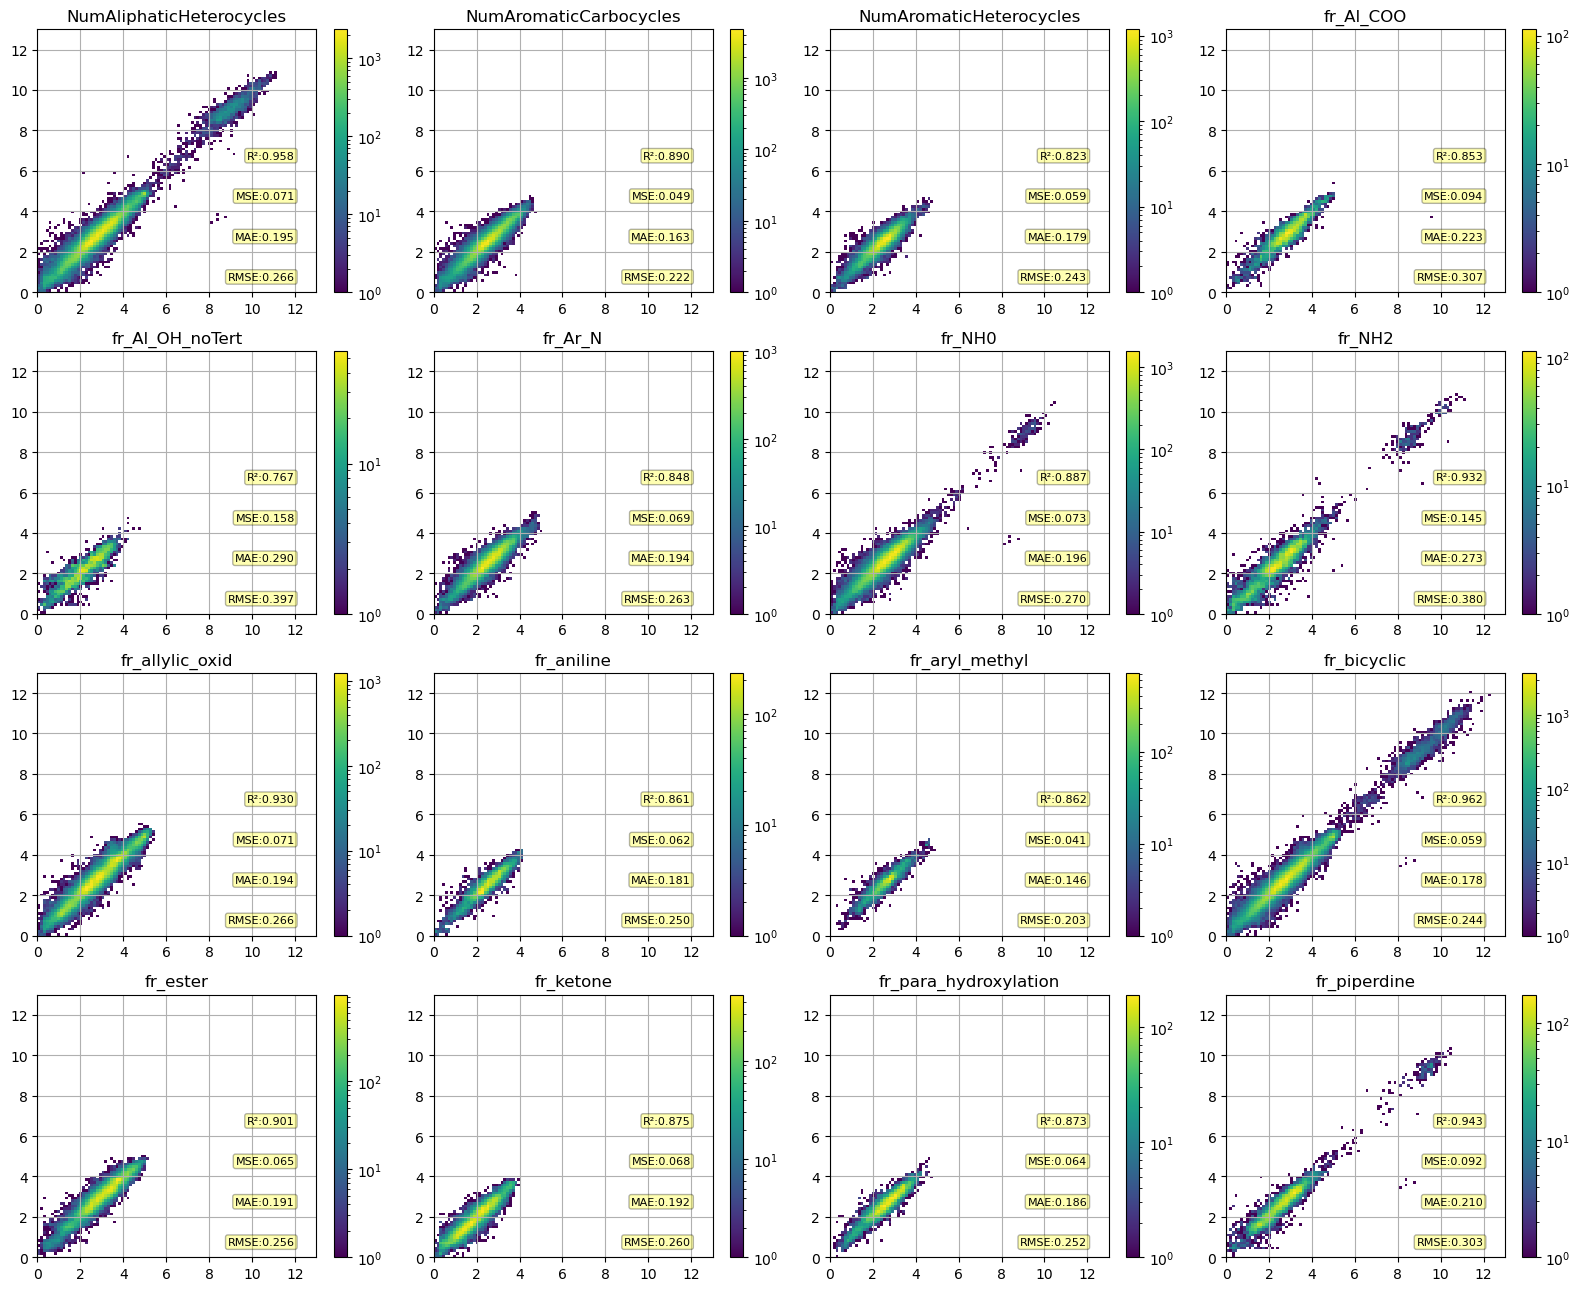

In [30]:
fig, axs = plt.subplots(math.ceil(count_feat/4),4, figsize=(16, 16))
#fig, axs = plt.subplots(math.ceil(count_feat/2),2, figsize=(12, 24))
axs = axs.ravel()
results=[]
num=0
for descr in df_concat.columns:
    if any(sub in descr for sub in ["Num","fr"]) and "NumRadicalElectrons" not in descr: #"Num", "fr"
        df_tmp= df_concat[df_concat[descr]>1]
        # Generate new heatmap for the column
        x = df_tmp['GAP']
        y = df_tmp['GAP_P']
        heatmap, xedges, yedges = np.histogram2d(x, y, bins=100, range=[[0,13],[0,13]],density=False)
        vmin = heatmap[heatmap > 0].min()
        vmax = heatmap.max()
        im = axs[num].pcolormesh(xedges, yedges, heatmap.T, cmap='viridis', shading='auto',norm=LogNorm(vmin=vmin, vmax=vmax))
        fig.colorbar(im, ax=axs[num]) #), label='number of molecules',)
        r2,mse,mae,rmse=get_metrics(df_tmp,"GAP_P","GAP")
        print(r2,mse,mae,rmse)
        results.append({
            "descriptor": descr,
            "R2": r2,
            "MSE": mse,
            "MAE": mae,
            "RMSE": rmse,
        })
        axs[num].set_title(f"{descr}")
        #axs[num].set_xlabel("GAP_P [eV]")
        #axs[num].set_ylabel("GAP [eV]")
        axs[num].text(
            12,  # x-coordinate of the text
            6.5,  # y-coordinate of the text
            f"R²:{r2:.3f}",  # The text string
            fontsize=8,  # Font size
            color='k',  # Text color
            ha='right',  # Horizontal alignment ('left', 'center', 'right')
            va='bottom',  # Vertical alignment ('top', 'center', 'bottom', 'baseline')
            bbox=dict(facecolor='yellow', alpha=0.3, edgecolor='black', boxstyle='round,pad=0.2') # Add a background box
        )
        axs[num].text(
            12,  # x-coordinate of the text
            4.5,  # y-coordinate of the text
            f"MSE:{mse:.3f}",  # The text string
            fontsize=8,  # Font size
            color='k',  # Text color
            ha='right',  # Horizontal alignment ('left', 'center', 'right')
            va='bottom',  # Vertical alignment ('top', 'center', 'bottom', 'baseline')
            bbox=dict(facecolor='yellow', alpha=0.3, edgecolor='black', boxstyle='round,pad=0.2') # Add a background box
        )
        axs[num].text(
            12,  # x-coordinate of the text
            2.5,  # y-coordinate of the text
            f"MAE:{mae:.3f}",  # The text string
            fontsize=8,  # Font size
            color='k',  # Text color
            ha='right',  # Horizontal alignment ('left', 'center', 'right')
            va='bottom',  # Vertical alignment ('top', 'center', 'bottom', 'baseline')
            bbox=dict(facecolor='yellow', alpha=0.3, edgecolor='black', boxstyle='round,pad=0.2') # Add a background box
        )
        axs[num].text(
            12,  # x-coordinate of the text
            0.5,  # y-coordinate of the text
            f"RMSE:{rmse:.3f}",  # The text string
            fontsize=8,  # Font size
            color='k',  # Text color
            ha='right',  # Horizontal alignment ('left', 'center', 'right')
            va='bottom',  # Vertical alignment ('top', 'center', 'bottom', 'baseline')
            bbox=dict(facecolor='yellow', alpha=0.3, edgecolor='black', boxstyle='round,pad=0.2') # Add a background box
        )
        axs[num].set_xticks([0,2,4,6,8,10,12])
        axs[num].set_yticks([0,2,4,6,8,10,12])
        axs[num].set_xlim(0, 13)
        axs[num].set_ylim(0, 13)
        axs[num].grid()
        #fig.colorbar(im, ax=axs[num], label="Counts")
        #break  # Remove this if you want to create more subplots for other columns
        num+=1
# Hide any unused subplots
for j in range(num, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.savefig("feature_distribution_4x4.png")
plt.show()

In [18]:
metrics_df = pd.DataFrame(results)
metrics_df.sort_values(by="R2",ascending=False)
metrics_df.style.format({"R2": "{:.3f}", "MSE": "{:.3f}", "MAE": "{:.3f}", "RMSE": "{:.3f}"})

,descriptor,R2,MSE,MAE,RMSE
0,NumAliphaticHeterocycles,0.958,0.071,0.195,0.266
1,NumAromaticCarbocycles,0.890,0.049,0.163,0.222
2,NumAromaticHeterocycles,0.823,0.059,0.179,0.243
3,fr_Al_COO,0.853,0.094,0.223,0.307
4,fr_Al_OH_noTert,0.767,0.158,0.290,0.397
5,fr_Ar_N,0.848,0.069,0.194,0.263
6,fr_NH0,0.887,0.073,0.196,0.270
7,fr_NH2,0.932,0.145,0.273,0.380
8,fr_allylic_oxid,0.930,0.071,0.194,0.266
9,fr_aniline,0.861,0.062,0.181,0.250
